# Adding xh/yh as variables for initial conditions code

In [3]:
# load Andrews IC file and check

import xarray as xr

andr = xr.open_dataset("/Users/james/Downloads/soda_ic_75z_1980-01-01.nc")
andr

<xarray.Dataset>
Dimensions:  (time: 1, xh: 720, xq: 721, yh: 360, yq: 361, zl: 75)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01
  * zl       (zl) float64 1.0 3.0 5.0 7.0 ... 5.875e+03 6.125e+03 6.375e+03
Dimensions without coordinates: xh, xq, yh, yq
Data variables:
    temp     (time, zl, yh, xh) float64 ...
    salt     (time, zl, yh, xh) float64 ...
    ssh      (time, yh, xh) float64 ...
    u        (time, zl, yh, xq) float64 ...
    v        (time, zl, yq, xh) float64 ...

In [4]:
mine = xr.open_dataset("/Users/james/Downloads/nwa25_soda_ic_75z_2010-01-05.nc")
mine

<xarray.Dataset>
Dimensions:  (time: 1, xh: 1550, xq: 1551, yh: 1690, yq: 1691, zl: 75)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-05T13:00:00
  * zl       (zl) float64 1.0 3.0 5.0 7.0 ... 5.875e+03 6.125e+03 6.375e+03
Dimensions without coordinates: xh, xq, yh, yq
Data variables:
    temp     (time, zl, yh, xh) float64 ...
    salt     (time, zl, yh, xh) float64 ...
    ssh      (time, yh, xh) float64 ...
    u        (time, zl, yh, xq) float64 ...
    v        (time, zl, yq, xh) float64 ...
Attributes:
    regrid_method:  bilinear

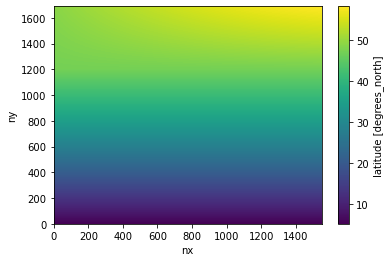

In [19]:
hgrid = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa25/netcdf3/land_mask.nc")
hgrid.y.plot()

In [ ]:
# 10/19/2021
# Trying to get "xh" and "yh" to behave as variables within the tracer initial conditions file.
# MOM6 demands that these be variables as opposed to just dimensions
# 
import numpy as np
import xarray
import xesmf
from numba import njit
import numpy as np
from dask.base import tokenize
import dask.array as dsa
import xarray as xr
import dask 
# https://github.com/raphaeldussin/HCtFlood
# code courtesy of Raphael Dussin - https://github.com/raphaeldussin/HCtFlood/blob/master/HCtFlood/kara.py
from HCtFlood import kara as flood

def vgrid_to_interfaces(vgrid, max_depth=6500.0):
    """Convert layer thicknesses to interface depths.

    Args:
        vgrid: array of layer thicknesses.
        max_depth: maximum depth of the model. The lowest interface depth will be set to this.

    Returns:
        Array of interface depths.     
    """
    if isinstance(vgrid, xarray.DataArray):
        vgrid = vgrid.data
    zi = np.concatenate([[0], np.cumsum(vgrid)])
    zi[-1] = max_depth
    return zi


def vgrid_to_layers(vgrid, max_depth=6500.0):
    """Convert layer thicknesses to depths of layer midpoints.

    Args:
        vgrid: array of layer thicknesses.
        max_depth: maximum depth of the model. The lowest interface depth will be set to this.

    Returns:
        Array of layer depths.     
    """
    if isinstance(vgrid, xarray.DataArray):
        vgrid = vgrid.data
    ints = vgrid_to_interfaces(vgrid, max_depth=max_depth)
    z = (ints + np.roll(ints, shift=1)) / 2
    layers = z[1:]
    return layers


def rotate_uv(u, v, angle, in_degrees=False):
    """Rotate velocities from earth-relative to model-relative.

    Args:
        u: west-east component of velocity.
        v: south-north component of velocity.
        angle: angle of rotation from true north to model north.
        in_degrees (bool): typically angle is in radians, but set this to True if it is in degrees.

    Returns:
        Model-relative west-east and south-north components of velocity.
    """
    if in_degrees:
        angle = np.radians(angle)
    urot = np.cos(angle) * u + np.sin(angle) * v
    vrot = -np.sin(angle) * u + np.cos(angle) * v
    return urot, vrot


def interpolate_flood_tracers(ds, target_grid):
    """Interpolate and flood data at tracer points (temperature, salinity, free surface).

    Args:
        ds (xarray.Dataset): Dataset with variables temp, salt, and ssh.
        target_grid (xarray.Dataset): Model supergrid with variables x, y and coords nxp, nyp.

    Returns:
        xarray.Dataset: Dataset flooded and interpolated to MOM tracer grid. 
    """
    # Flood temperature and salinity over land.
    flooded = xarray.merge((
        flood.flood_kara(ds[v], zdim='zl') for v in ['temp', 'salt']
    ))
    
    # Flood ssh separately to avoid extra z=0
    flooded['ssh'] = flood.flood_kara(ds['ssh']).isel(z=0).drop('z')
    
    # Interpolate
    target_points = (
        target_grid
        [['x', 'y']]
        .isel(nxp=slice(1, None, 2), nyp=slice(1, None, 2))
        .rename({'y': 'lat', 'x': 'lon', 'nxp': 'xh', 'nyp': 'yh'})
    )
    soda_to_mom = xesmf.Regridder(
        flooded, 
        target_points, 
        method='bilinear', 
        filename='regrid_soda_tracers.nc',
        reuse_weights=True,
        periodic=True
    )
    interped = soda_to_mom(flooded).drop(['lon', 'lat'])
    return interped


def interpolate_flood_velocity(ds, target_grid):
    """Interpolate and flood velocity data.

    Args:
        ds (xarray.Dataset): Dataset with variables u and v.
        target_grid (xarray.Dataset): Model supergrid with variables x, y and coords nxp, nyp.

    Returns:
        xarray.Dataset: Dataset flooded and interpolated to MOM velocity grid. 
    """
    # Flood over land.
    flooded = xarray.merge((
        flood.flood_kara(ds[v], zdim='zl') for v in ['u', 'v']
    ))

    # Interpolate u and v onto supergrid to make rotation possible
    target_uv = (
        target_grid
        [['x', 'y']]
        .rename({'y': 'lat', 'x': 'lon'})
    )
    soda_to_uv = xesmf.Regridder(
        ds, target_uv, 
        filename='regrid_soda_uv.nc',
        method='nearest_s2d',
        reuse_weights=True,
        periodic=True
    )

    interped_uv = soda_to_uv(flooded[['u', 'v']]).drop(['lon', 'lat'])
    urot, vrot = rotate_uv(interped_uv['u'], interped_uv['v'], target_grid['angle_dx'])
    # Subset onto u and v points.
    uo = urot.isel(nxp=slice(0, None, 2), nyp=slice(1, None, 2)).rename({'nxp': 'xq', 'nyp': 'yh'})
    uo.name = 'u'
    vo = vrot.isel(nxp=slice(1, None, 2), nyp=slice(0, None, 2)).rename({'nxp': 'xh', 'nyp': 'yq'})
    vo.name = 'v'
    
    interped = (
        xarray.merge((uo, vo))
        .transpose('time', 'zl', 'yh', 'yq', 'xh', 'xq')
    )

    return interped 


def write_initial(soda_file, vgrid_file, grid_file, start_date, output_file):
    """Interpolate initial conditions for MOM from a SODA file and write to a new file.

    Args:
        soda_file (str): Path to SODA file to use for initial conditions.
        vgrid_file (str): Path to vertical grid to interpolate data to.
        grid_file (str): Path to horizontal grid file (ocean_hgrid.nc) to interpolate data to.
        start_date (np.datetime64): Overwrite the SODA datetime with this datetime. Useful if model start date and SODA 5-day dates do not match.
        output_file (str): Write resulting initial conditions to this file.
    """
    vgrid = xarray.open_dataarray(vgrid_file)
    z = vgrid_to_layers(vgrid)
    ztarget = xarray.DataArray(
        z,
        name='zl',
        dims=['zl'], 
        coords={'zl': z}
    )

    soda = (
        xarray.open_dataset(soda_file)
        .rename({'st_ocean': 'z'})
        [['temp', 'salt', 'ssh', 'u', 'v']]
    )

    # Interpolate SODA vertically onto target grid.
    # Depths below bottom of SODA are filled by extrapolating the deepest available value.
    revert = soda.interp(z=ztarget, kwargs={'fill_value': 'extrapolate'}).ffill('zl', limit=None)

    # Split SODA into data on tracer and velocity points
    tracers = revert[['temp', 'salt', 'ssh']].rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})
    velocity = revert[['u', 'v']].rename({'xu_ocean': 'lon', 'yu_ocean': 'lat'})
    

    # Horizontally interpolated the vertically interpolated
    # and flooded data onto the MOM grid.
    grid = xarray.open_dataset(grid_file)

    interped = xarray.merge((
        interpolate_flood_tracers(tracers, grid),
        interpolate_flood_velocity(velocity, grid)
    ))

    # Overwrite the SODA file time with the intended model start date.
    interped['time'] = (('time', ), [start_date])

    # Fix output metadata, including removing all _FillValues.
    all_vars = list(interped.data_vars.keys()) + list(interped.coords.keys())
    encodings = {v: {'_FillValue': None} for v in all_vars}
    encodings['time'].update({'dtype':'float64', 'calendar': 'gregorian'})
    encodings['temp'].update({'_FillValue':-1.e+20})
    encodings['salt'].update({'_FillValue':-1.e+20})
    encodings['ssh'].update({'_FillValue':-1.e+20})
    interped['zl'].attrs = {
        'units': 'meter',
        'cartesian_axis': 'Z',
        'positive': 'down'
    }

    interped.to_netcdf(
        output_file,
        format='NETCDF3_64BIT',
        engine='netcdf4',
        encoding=encodings,
        unlimited_dims='time'
    )

def main():
    # Model start date is 2010-01-05 13:00:00
    # https://dsrs.atmos.umd.edu/DATA/soda3.12.2/REGRIDED/ocean/soda3.12.2_5dy_ocean_reg_1993_01_04.nc
    #soda_file = f'/glade/scratch/jsimkins/SODA3.12.2/soda3.12.2_5dy_ocean_reg_1993_01_04.nc'
    soda_file = '/home/james/SODA/5day/soda3.3.1_5dy_ocean_reg_2010_01_05.nc'
    
    #start_date = np.datetime64('1993-01-02T00:00:00')
    start_date = np.datetime64('2010-01-05T13:00:00')
    # Used in filename below, don't change
    start_str = np.datetime_as_string(start_date, unit='D')
    
    # Save the ICs here:
    #output_file = f'/glade/u/home/jsimkins/obc_ic/nwa25/nwa25_soda_ic_75z_{start_str}.nc'
    output_file = f'/home/james/initCond/nwa25/nwa25_soda_ic_75z_{start_str}.nc'
    
    # Model vertical grid:
    #vgrid_file = '/glade/u/home/jsimkins/obc_ic/nwa25/vgrid_zl.nc'
    #vgrid_file = '/home/james/gridInfo/nwa25/vgrid_41_2m.nc'
    vgrid_file = '/home/james/gridInfo/nwa25/vgrid_75_2m.nc'
    
    # Model horizontal grid:
    #grid_file = '/glade/u/home/jsimkins/obc_ic/nwa25/nwa25_ocean_hgrid.nc'
    grid_file = '/home/james/gridInfo/nwa25/nwa25_ocean_hgrid.nc'
    
    write_initial(soda_file, vgrid_file, grid_file, start_date, output_file)
    
    # copy xh/yh from land mask file here
    out = xr.open_dataset(output_file)
    land = xr.open_dataset("/home/james/gridInfo/nwa25/land_mask.nc")
    out = out.assign_coords(xh=land['x'], yh=land['y'])
    out['ny'] = out.ny
    out['nx'] = out.nx
    out.to_netcdf(output_file,format='NETCDF3_64BIT', mode='w')
    
if __name__ == '__main__':
    main()

In [32]:
import xarray as xr

ocean = xr.open_dataset("../../grid_gen/gridInfo/nwa25/ocean_mask.nc")
# Interpolate
land = xr.open_dataset("../../grid_gen/gridInfo/nwa25/netcdf3/land_mask.nc")
ocean['x'] = land['x']
ocean['y'] = land['y']

ocean.to_netcdf("../../grid_gen/gridInfo/nwa25/netcdf3/ocean_mask.nc",format='NETCDF3_64BIT', mode='w')

In [36]:
ocean = xr.open_dataset("../../grid_gen/gridInfo/nwa25/netcdf3/ocean_mask.nc")

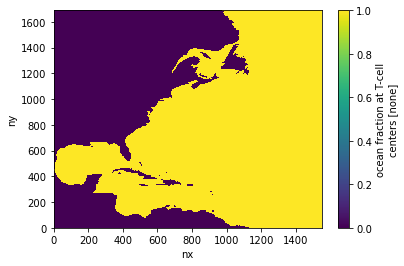

In [37]:
ocean.mask.plot()

In [38]:
ocean.y.values

array([[ 5.25262005,  5.25262005,  5.25262005, ...,  5.25262005,
         5.25262005,  5.25262005],
       [ 5.29243896,  5.29243896,  5.29243896, ...,  5.29243896,
         5.29243896,  5.29243896],
       [ 5.33225548,  5.33225548,  5.33225548, ...,  5.33225548,
         5.33225548,  5.33225548],
       ...,
       [48.75403376, 48.76269035, 48.77134503, ..., 58.11402699,
        58.11670405, 58.11937729],
       [48.75744119, 48.76611493, 48.77478676, ..., 58.13471179,
        58.13739647, 58.14007353],
       [48.76085051, 48.7695395 , 48.77822659, ..., 58.15538897,
        58.15807746, 58.16076214]])

In [42]:
# test out the adding of dimensions and / or coordinates
output_file = f'/Users/james/Downloads/nwa25_soda_ic_75z_2010-01-05.nc'

out = xr.open_dataset(output_file)
land = xr.open_dataset("/Users/james/Documents/Github/esm_lab/grid_gen/gridInfo/nwa25/netcdf3/land_mask.nc")
out = out.assign_coords(xh=land['x'], yh=land['y'])
out
#out.to_netcdf(output_file,format='NETCDF3_64BIT', mode='w')

<xarray.Dataset>
Dimensions:  (nx: 1550, ny: 1690, time: 1, xh: 1550, xq: 1551, yh: 1690, yq: 1691, zl: 75)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-05T13:00:00
  * zl       (zl) float64 1.0 3.0 5.0 7.0 ... 5.875e+03 6.125e+03 6.375e+03
    xh       (ny, nx) float64 ...
    yh       (ny, nx) float64 ...
Dimensions without coordinates: nx, ny, xq, yq
Data variables:
    temp     (time, zl, yh, xh) float64 ...
    salt     (time, zl, yh, xh) float64 ...
    ssh      (time, yh, xh) float64 ...
    u        (time, zl, yh, xq) float64 ...
    v        (time, zl, yq, xh) float64 ...
Attributes:
    regrid_method:  bilinear

In [48]:
land

<xarray.Dataset>
Dimensions:  (nx: 1550, ny: 1690)
Dimensions without coordinates: nx, ny
Data variables:
    mask     (ny, nx) int32 ...
    x        (ny, nx) float64 ...
    y        (ny, nx) float64 ...
Attributes:
    grid_version:  0.2
    code_version:  ESMG/gridtools: ['heads/main-0-g542f2493bc-dirty', '']
    history:       2021-10-18: gridtools.grid.mom6.convert_ROMS_to_MOM6 + kwargs

In [49]:
out

<xarray.Dataset>
Dimensions:  (nx: 1550, ny: 1690, time: 1, xh: 1550, xq: 1551, yh: 1690, yq: 1691, zl: 75)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-05T13:00:00
  * zl       (zl) float64 1.0 3.0 5.0 7.0 ... 5.875e+03 6.125e+03 6.375e+03
    xh       (ny, nx) float64 ...
    yh       (ny, nx) float64 ...
  * ny       (ny) int64 0 1 2 3 4 5 6 7 ... 1683 1684 1685 1686 1687 1688 1689
  * nx       (nx) int64 0 1 2 3 4 5 6 7 ... 1543 1544 1545 1546 1547 1548 1549
Dimensions without coordinates: xq, yq
Data variables:
    temp     (time, zl, yh, xh) float64 ...
    salt     (time, zl, yh, xh) float64 ...
    ssh      (time, yh, xh) float64 ...
    u        (time, zl, yh, xq) float64 ...
    v        (time, zl, yq, xh) float64 ...
Attributes:
    regrid_method:  bilinear